In [2]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 9.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 9.9 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


## Importing all required libraries

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

## Load and Preprocess Data

In [2]:
def load_and_preprocess(directory, label=None):
    data_frames = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(directory, file))
            if label is not None:
                df["label"] = label  # Assign class labels
            data_frames.append(df)
    df = pd.concat(data_frames, ignore_index=True)

    # ✅ Handle categorical data
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = LabelEncoder().fit_transform(df[col])

    # ✅ Handle missing values
    df.fillna(df.median(), inplace=True)

    return df


In [20]:
healthy_dir = "../split_fif//healthy_csv"
mdd_dir = "../split_fif/mdd_csv"


In [21]:
df_healthy = load_and_preprocess(healthy_dir, label=0)  # 0 for Healthy
df_mdd = load_and_preprocess(mdd_dir, label=1)  # 1 for MDD

In [22]:
df_mdd.head()

,ec_fp1_mean,ec_fp1_variance,ec_fp1_skewness,ec_fp1_kurtosis,ec_fp1_peak_to_peak,ec_fp1_fft_mean,ec_fp1_fft_std,ec_fp1_fft_max,ec_fp1_wavelet_energy,ec_fp1_wavelet_entropy,...,eo_p7_gamma_power,eo_p3_gamma_power,eo_pz_gamma_power,eo_p4_gamma_power,eo_p8_gamma_power,eo_o1_gamma_power,eo_oz_gamma_power,eo_o2_gamma_power,eof3_f4_alpha_asymmetry,label
0,3.062341e-08,1.573311e-10,0.187885,0.345930,0.000100,0.000627,0.002080,0.037171,0.000262,39.845524,...,3.638405e-13,3.208221e-13,2.840619e-13,3.092196e-13,2.405757e-13,2.007456e-13,1.841832e-13,2.021835e-13,2.270847e-12,1
1,1.100294e-07,1.181934e-10,0.184373,0.416713,0.000096,0.000560,0.001798,0.039566,0.000082,28.254055,...,3.029673e-13,2.103071e-13,1.763250e-13,1.757361e-13,5.017585e-13,1.044772e-12,7.260578e-13,3.807092e-13,3.085955e-13,1
2,-9.711022e-08,8.813913e-11,0.972847,7.633421,0.000155,0.000515,0.001542,0.034694,0.000068,25.244156,...,6.345380e-14,7.357853e-14,7.212235e-14,6.005163e-14,5.488644e-14,5.889268e-14,5.463147e-14,4.930437e-14,-3.268018e-13,1
3,-6.697500e-08,8.902382e-11,-0.112628,0.750671,0.000092,0.000454,0.001570,0.036079,0.000058,23.052350,...,3.500329e-13,4.011288e-13,3.552496e-13,4.382360e-13,2.145847e-12,6.580347e-13,5.532881e-13,6.853001e-13,-2.071186e-13,1
4,8.848696e-09,1.597564e-10,0.124087,0.410220,0.000107,0.000709,0.002071,0.032687,0.000134,35.530008,...,6.307009e-13,4.225037e-13,4.328805e-13,3.902828e-13,3.880236e-13,4.277317e-13,3.911162e-13,3.972426e-13,1.836482e-13,1


In [22]:
df_healthy.head()

,condition,channel,mean,variance,skewness,kurtosis,peak_to_peak,fft_mean,fft_std,fft_max,wavelet_energy,delta_power,theta_power,slow_alpha_power,alpha_power,beta_power,gamma_power,label
0,1,15,-1.245248e-07,1.499998e-10,0.007460,0.639596,0.000122,0.001087,0.002804,0.036131,0.000009,6.072270e-12,1.169391e-12,1.097573e-12,1.312075e-12,3.564100e-12,2.450911e-12,0
1,1,16,-6.899819e-08,2.127206e-10,0.034860,0.189885,0.000138,0.001290,0.003341,0.034268,0.000013,6.972012e-12,1.154292e-12,1.102830e-12,1.271315e-12,5.553507e-12,3.528987e-12,0
2,1,10,-2.820214e-08,7.162006e-11,-0.030376,0.316850,0.000080,0.000693,0.001959,0.039144,0.000004,6.794530e-12,1.068254e-12,8.200473e-13,9.638955e-13,1.060505e-12,5.529987e-13,0
3,1,7,1.043341e-08,6.638092e-11,-0.040471,0.190540,0.000083,0.000720,0.001867,0.030298,0.000004,4.702409e-12,1.356930e-12,1.241118e-12,1.392578e-12,1.246519e-12,7.034063e-13,0
4,1,17,-3.541077e-08,5.546140e-11,-0.096979,0.337450,0.000073,0.000613,0.001723,0.037295,0.000003,5.505811e-12,1.716387e-12,1.661329e-12,1.919792e-12,7.071352e-13,2.832589e-13,0


In [5]:
scaler = StandardScaler()

In [6]:
df = pd.concat([df_healthy, df_mdd], axis=0).reset_index(drop=True)

In [7]:
X = df.drop(columns=['label']).values
y = df['label'].values

In [8]:
X_flattened = X.reshape(X.shape[0], -1)  # (samples, features)

# ✅ Apply StandardScaler
X_scaled = scaler.fit_transform(X_flattened)

# ✅ Reshape back to ensure correct dimensions
X = X_scaled  # Keeps it 2D for ML models

print(f"✅ Data Shape after Standardization: {X.shape}")  # Should be (samples, features)

# ================================
# 🔹 Split into Train, Validation & Test
# ================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.2,  # Reserve 20% for validation & test  
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.3,  # 30% of temp set → 6% of total data
    random_state=42,
    stratify=y_temp
)

✅ Data Shape after Standardization: (7140, 17)


In [9]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# ✅ Convert to NumPy (if not already) and ensure correct dtype
X_train_np = np.array(X_train, dtype=np.float32)
y_train_np = np.array(y_train, dtype=np.float32)
X_val_np = np.array(X_val, dtype=np.float32)

# ✅ XGBoost Model with GPU Optimization
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",  # ✅ Correct method for GPU in XGBoost 2.0+
    device="cuda",  # ✅ Explicitly set device to GPU
    eval_metric="logloss",
    learning_rate=0.005,
    max_depth=20,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=2,
    reg_alpha=0.3,
    reg_lambda=1.5,
    n_estimators=3000,  # ✅ Lowered for efficiency
    verbosity=1
)

# ✅ Define Parameter Grid (For Fine-Tuning)
best_params = {
    'n_estimators': [4000],        
    'learning_rate': [0.002],       
    'max_depth': [25],              
    'gamma': [0.2],                  
    'subsample': [0.9],            
    'colsample_bytree': [0.9],     
    'reg_alpha': [0.1],             
    'reg_lambda': [3.0],            
    'min_child_weight': [1]         
}


# ✅ Use StratifiedKFold for Cross-Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ✅ GridSearchCV for Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=best_params, 
    scoring="accuracy",
    cv=cv,  # ✅ Use StratifiedKFold
    verbose=3,  
    n_jobs=1  # ✅ Ensures GPU execution inside XGBoost
)

# ✅ Train with GridSearchCV (Fully GPU-optimized)
grid_search.fit(X_train_np, y_train_np)  # 🚀 Data will be loaded into GPU inside XGBoost

# ✅ Best Hyperparameters
print("🔥 Best Parameters:", grid_search.best_params_)

# ✅ Test on Validation Set
best_model = grid_search.best_estimator_
val_preds = best_model.predict(X_val_np)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:34:39] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.002, max_depth=25, min_child_weight=1, n_estimators=4000, reg_alpha=0.1, reg_lambda=3.0, subsample=0.9;, score=0.780 total time=  20.7s
[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.002, max_depth=25, min_child_weight=1, n_estimators=4000, reg_alpha=0.1, reg_lambda=3.0, subsample=0.9;, score=0.799 total time=  21.0s
[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.002, max_depth=25, min_child_weight=1, n_estimators=4000, reg_alpha=0.1, reg_lambda=3.0, subsample=0.9;, score=0.830 total time=  21.4s
🔥 Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.002, 'max_depth': 25, 'min_child_weight': 1, 'n_estimators': 4000, 'reg_alpha': 0.1, 'reg_lambda': 3.0, 'subsample': 0.9}


In [10]:
from sklearn.metrics import accuracy_score

# Training Accuracy
train_acc = best_model.score(X_train_np, y_train)  # Or use accuracy_score
print(f"Training Accuracy: {train_acc:.4f}")

# Validation Accuracy
val_acc = best_model.score(X_val_np, y_val)  # Or use accuracy_score
print(f"Validation Accuracy: {val_acc:.4f}")

# Alternative: Using accuracy_score explicitly
val_preds = best_model.predict(X_val_np)
val_acc_manual = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy (manual calculation): {val_acc_manual:.4f}")


Training Accuracy: 0.9912
Validation Accuracy: 0.8438
Validation Accuracy (manual calculation): 0.8438


In [42]:
pip install shap

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 10.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 10.7 MB/s eta 0:00:0000:0100:01
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 10.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.3
    Uninstalling numpy-2.2.3:
      Successfully uninstalled numpy-2.2.3
Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install numpy==2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 10.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
Note: you may need to restart the kernel to use updated packages.


/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


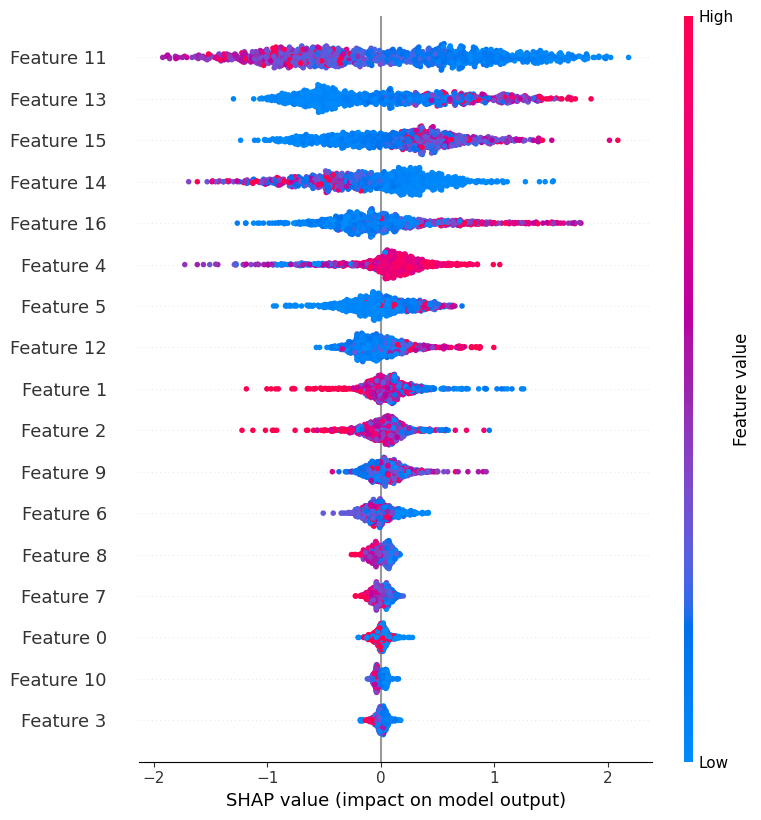

TypeError: Object of type float32 is not JSON serializable

In [11]:
import shap
from .autonotebook import tqdm as notebook_tqdm

explainer = shap.Explainer(best_model)
shap_values = explainer(X_val_np)

# ✅ Summary Plot
shap.summary_plot(shap_values, X_val_np)

# ✅ Force Plot (for the first prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0].values, X_val_np[0])

# Full Code